In [16]:
import tqdm
import itertools

import datamol as dm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from mood.constants import DOWNSTREAM_RESULTS_DIR
from mood.dataset import MOOD_DATASETS
from mood.representations import MOOD_REPRESENTATIONS
from mood.baselines import SUPPORTED_BASELINES
from mood.utils import get_outlier_bounds
from mood.metrics import Metric

In [17]:
SUBDIR = "20221213"

In [18]:
in_dir = dm.fs.join(DOWNSTREAM_RESULTS_DIR, "dataframes", "compare_performance", SUBDIR)
pattern = dm.fs.join(in_dir, "gap_*.csv")
paths = dm.fs.glob(pattern)

In [19]:
def find_missing(paths, all_triplets):
    triplets = []
    for path in paths:
        path = dm.fs.get_basename(path)
        path = ".".join(path.split(".")[:-1])
        triplet = tuple(path.split("_")[1:])
        triplets.append(triplet)
    missing = set(all_triplets) - set(triplets)
    
    msg = f"Missing {len(missing)}:\n"
    for m in sorted(missing): 
        msg += f"{m}\n"
    return msg 
                        

all_triplets = list(itertools.product(MOOD_DATASETS, SUPPORTED_BASELINES, MOOD_REPRESENTATIONS))
assert list(all_triplets) == len(paths), find_missing(paths, all_triplets)

AssertionError: Missing 9:
('CYP2C9', 'GP', 'ChemBERTa')
('CYP2C9', 'GP', 'Desc2D')
('CYP2C9', 'GP', 'ECFP6')
('CYP2C9', 'GP', 'Graphormer')
('CYP2C9', 'GP', 'MACCS')
('CYP2C9', 'GP', 'WHIM')
('Lipophilicity', 'RF', 'ChemBERTa')
('Lipophilicity', 'RF', 'Graphormer')
('PPBR', 'RF', 'ChemBERTa')


In [ ]:
df_original = pd.concat([pd.read_csv(p) for p in tqdm.tqdm(paths)], ignore_index=True)
# The "P450" is actually not informative, but these results were generated before abbreviating the name
df_original["dataset"] = df_original["dataset"].apply(lambda x: "CYP2C9" if x == "CYPP4502C9" else x)

In [ ]:
df_original.groupby(["type", "metric"])[["iid_score", "ood_score"]].describe()

In [ ]:
# Make a copy to keep the original intact. 
# Useful for experimentation, as creating the dataframe can be slow
df = df_original.copy()

# Upscale the Spearman correlation to go from [-1, 1] to [0, 1]
df.loc[df["metric"] == "Spearman", "iid_score"] = (df["iid_score"] + 1) / 2
df.loc[df["metric"] == "Spearman", "ood_score"] = (df["ood_score"] + 1) / 2

# A gap > 0; performance on OOD set was better
# We expect: Performance to be worse (so: Negative gaps)
df["gap"] = df["ood_score"] - df["iid_score"]

# Since we observed above that there is no negative scores
# We can also compute the relative change
# This is useful as the range to values for all targets is not the same (e.g. PPBR vs. Caco-2)
df["relative_gap"] = (df["gap"] / df["iid_score"]) * 100

# Invert the gap of metrics that need to be minimized, so that a high gap is always better
df["metric_direction"] = df["metric"].apply(lambda x: Metric.by_name(x).mode)
df.loc[df["gap"] == "min", "gap"] = -df["gap"]
df.loc[df["metric_direction"] == "min", "relative_gap"] = -df["relative_gap"]

df = df.rename(columns={"representation": "Representation", "dataset": "Dataset"})
df.head()

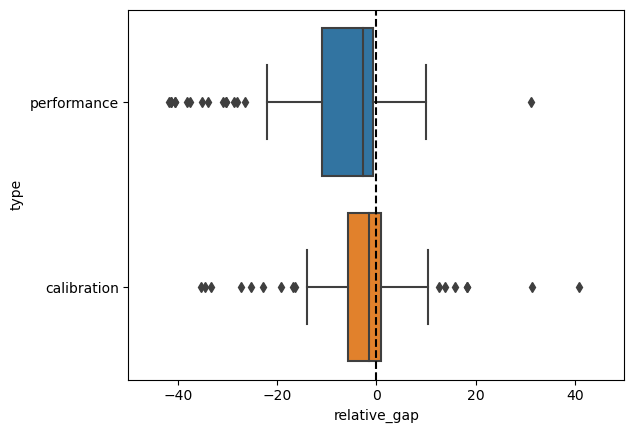

In [20]:
ax = sns.boxplot(data=df, x="relative_gap", y="type")
ax.set_xlim([-50, 50])
ax.plot([0, 0], ax.get_ylim(), "k--")

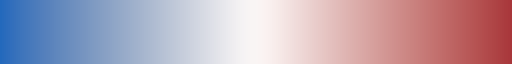

In [21]:
cmap = sns.color_palette("vlag", as_cmap=True)
cmap

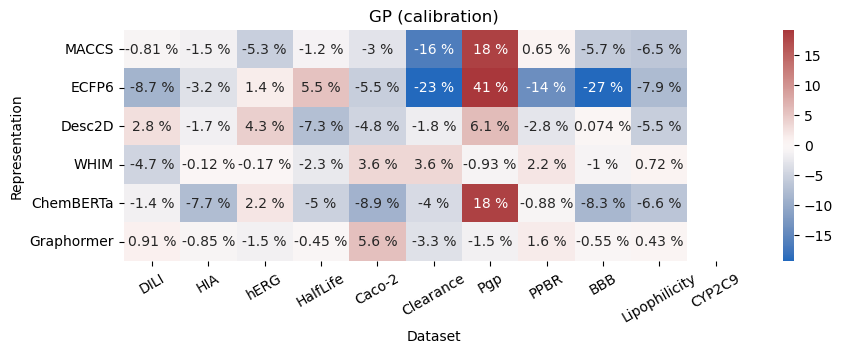

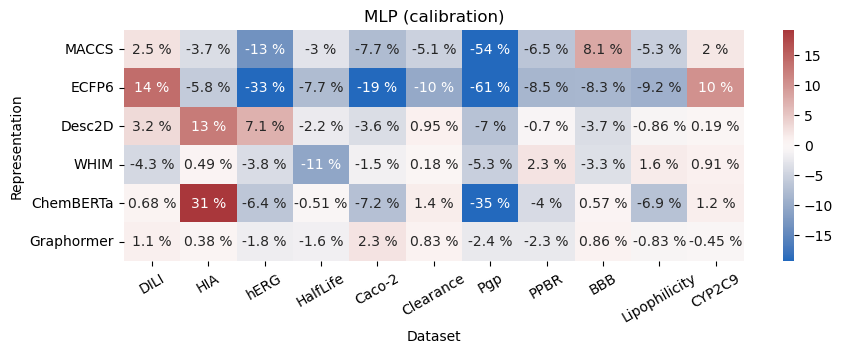

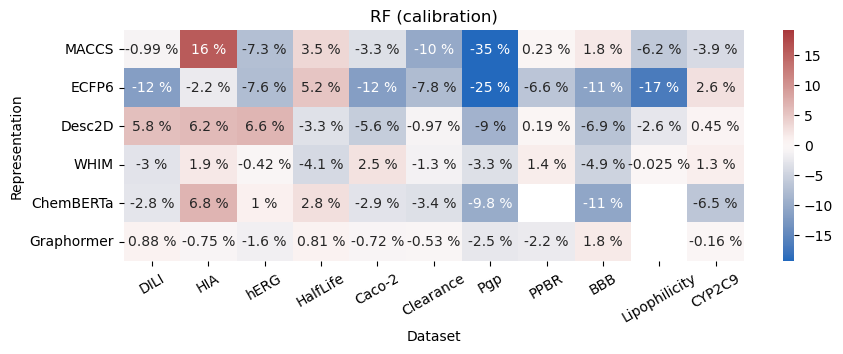

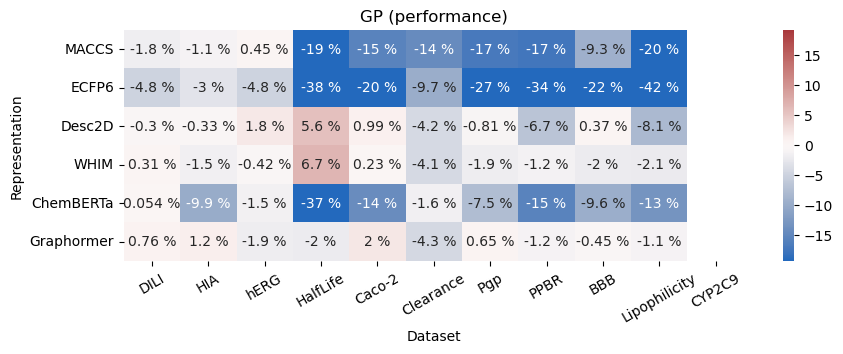

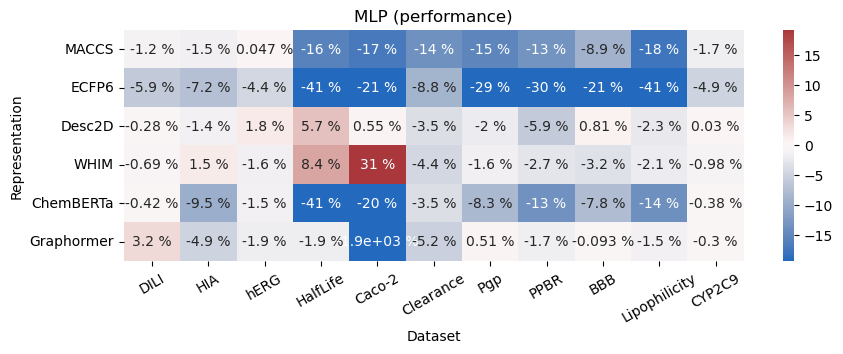

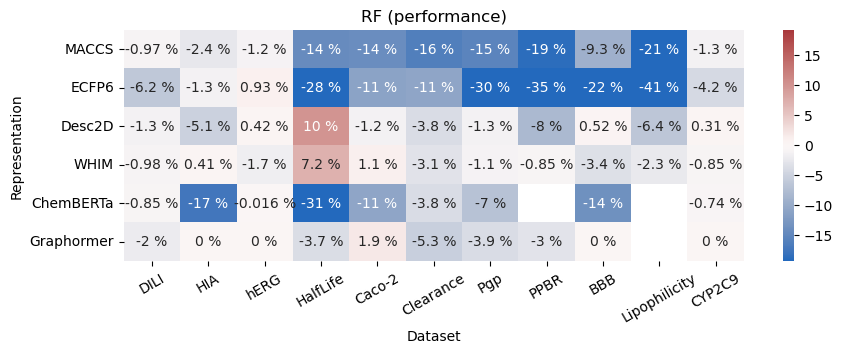

In [22]:
metric = "relative_gap"

lower, upper = get_outlier_bounds(df[metric].to_numpy())
vmin = min(lower, -upper)
vmax = -vmin

for metric_type, metric_group in df.groupby("type"):
        
    for idx, (name, group) in enumerate(metric_group.groupby("algorithm")):
        fig, ax = plt.subplots(figsize=(10, 3))
        pivot = group.pivot("Representation", "Dataset", metric)
        
        for c in MOOD_DATASETS: 
            if c not in pivot.columns:
                pivot[c] = np.nan
        pivot = pivot[MOOD_DATASETS]
        pivot = pivot.reindex(MOOD_REPRESENTATIONS)
        
        sns.heatmap(pivot, annot=True, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
        for t in ax.texts: t.set_text(t.get_text() + " %")
        ax.set_title(f"{name} ({metric_type})")

The End.